In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from src.features.extract_features import *
from src.data.dataset import *

In [5]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,3)
plt.rcParams["figure.max_open_warning"] = False
data_files = glob.glob(r"D:\Hagar\Downloads\data\*\*")

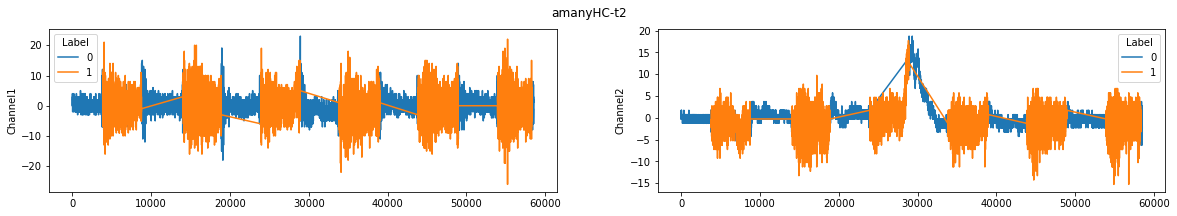

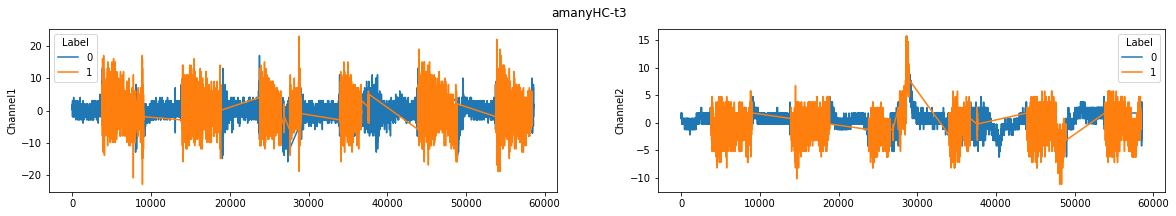

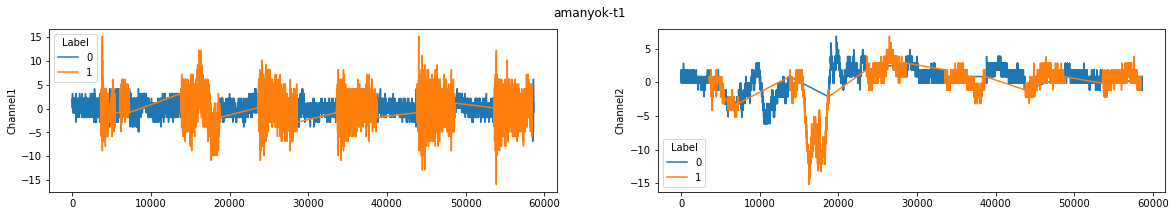

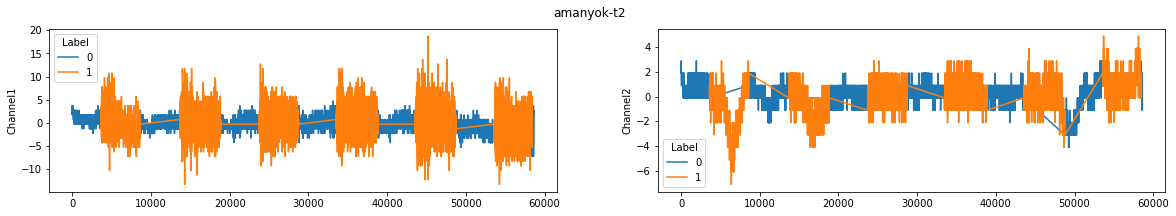

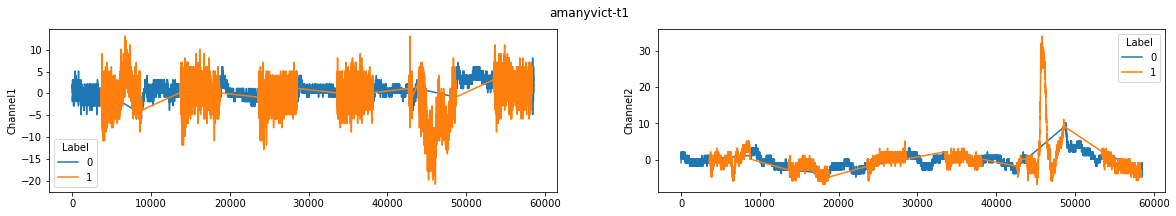

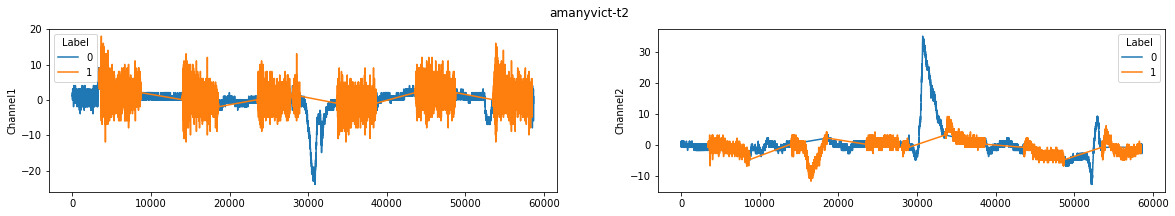

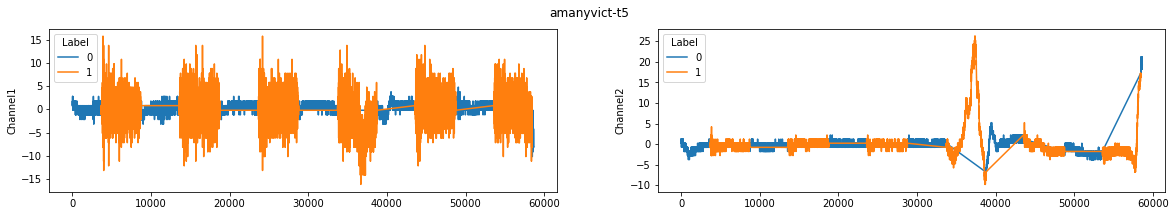

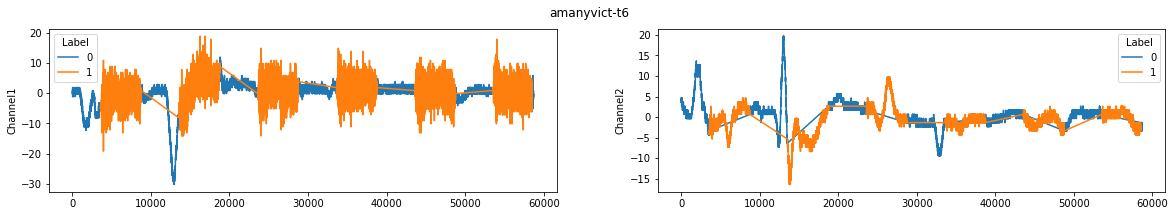

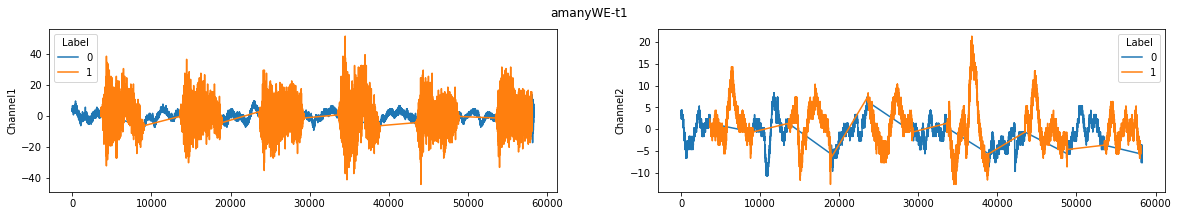

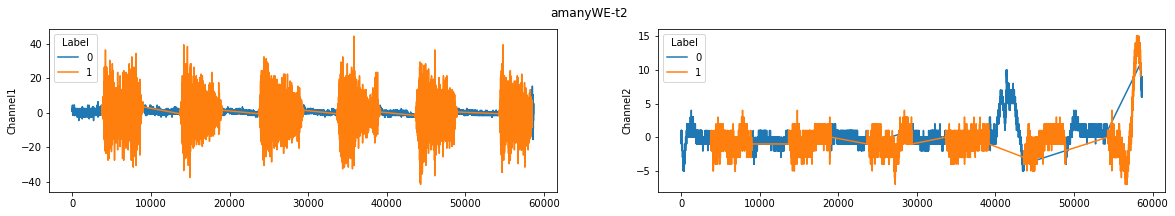

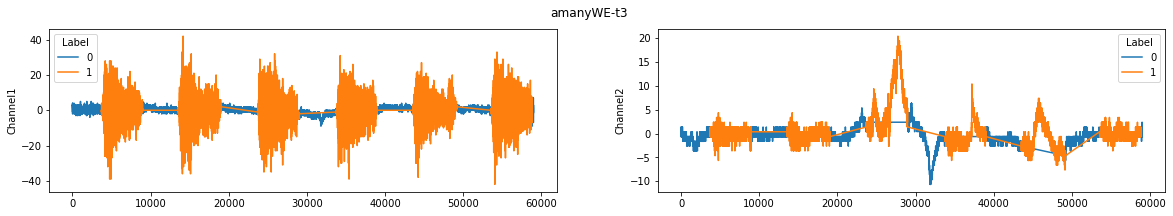

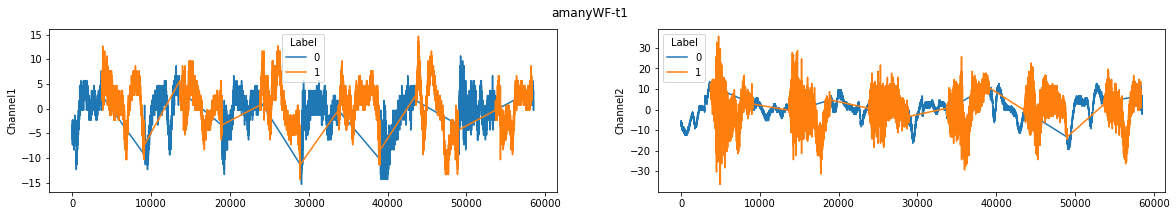

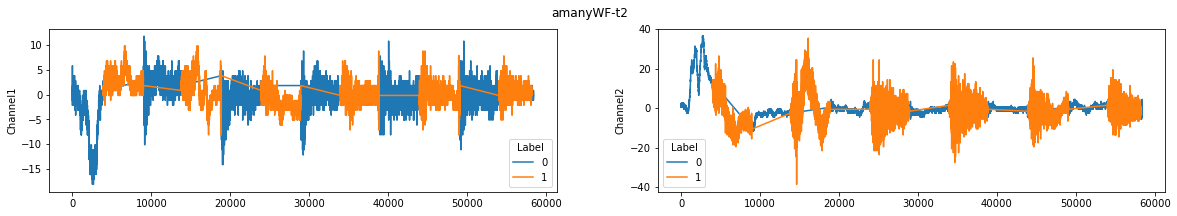

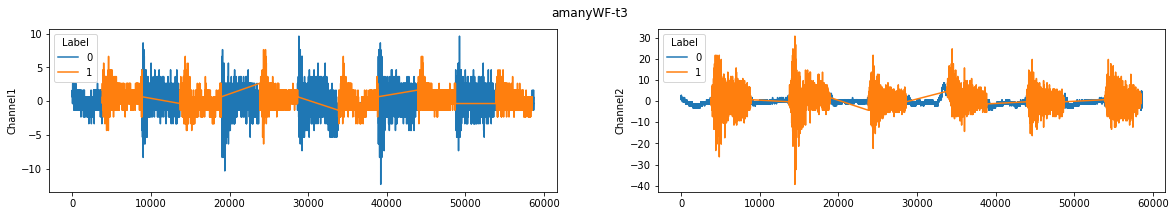

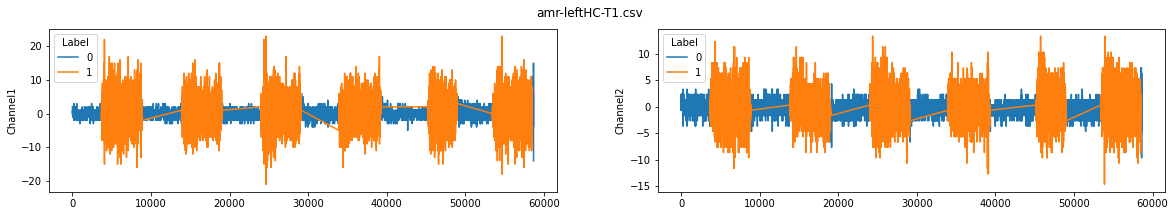

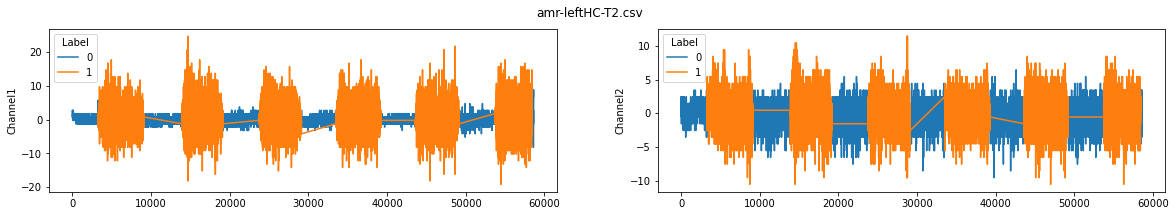

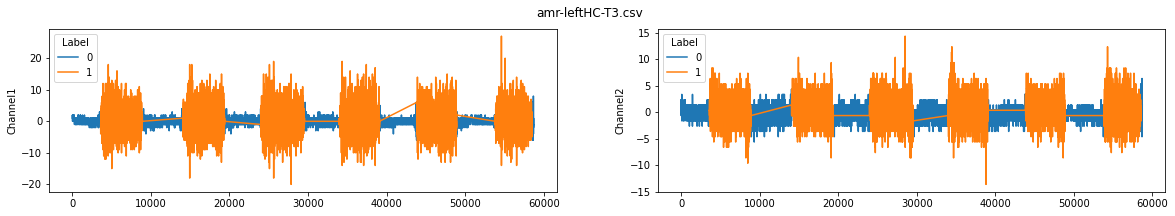

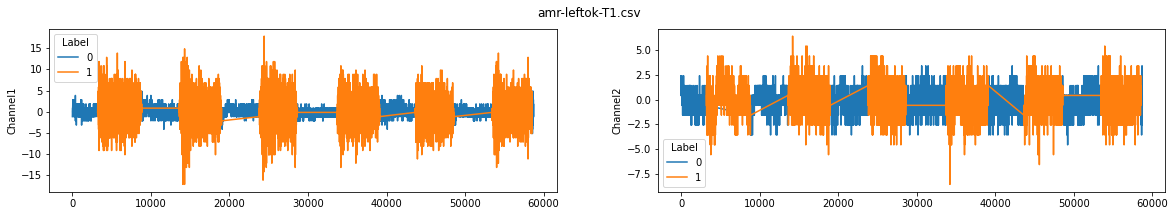

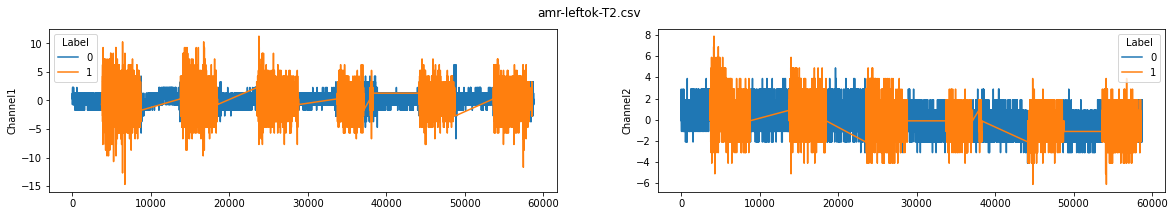

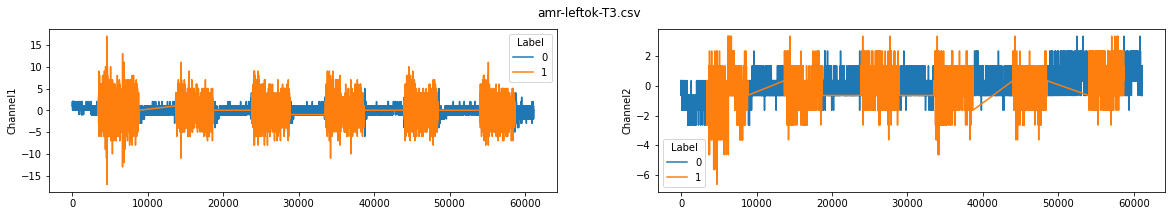

In [68]:
for file in data_files:
    data = pd.read_csv(file)
    
    ch1_mean = data.Channel1.mean()
    ch2_mean = data.Channel2.mean()
    data.Channel1 = data.Channel1.apply(lambda x: x - ch1_mean)
    data.Channel2 = data.Channel2.apply(lambda x: x - ch2_mean)
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    subject = file.split("\\")[-2]
    gesture = file.split("\\")[-1]
    fig.suptitle(subject + gesture)
    samples = np.arange(len(data.Channel1))
    sns.lineplot(data = data, x=samples, y = "Channel1", hue = "Label", ax=ax1)
    sns.lineplot(data = data, x=samples, y = "Channel2", hue = "Label", ax=ax2)

In [6]:
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow import keras
from keras import Sequential, layers, initializers, optimizers, losses

data_dir = r"D:\Hagar\Downloads\data"

def generate_dataset(data_dir, feature_set, win_size, win_stride, is_td=True):
    dataset = EmgDataset(data_dir, win_size, win_stride, feature_set, is_td)
    
    emg_features = dataset.extracted_features
    labels = dataset.rolled_labels
    reps = dataset.rolled_repetition
    
    train_rows = np.isin(reps, ['1','3','4']).ravel()
    test_rows = np.isin(reps, ['2']).ravel()

    train_emg = emg_features[train_rows]
    y_train = labels[train_rows].ravel()

    test_emg = emg_features[test_rows]
    y_test = labels[test_rows].ravel()

    print(f"X_train shape: {train_emg.shape} y_train shape: {y_train.shape}")
    print(f"X_test shape: {test_emg.shape} y_test shape: {y_test.shape}")
    
    y_train = y_train[~np.isnan(train_emg).any(axis=1)]
    train_emg = train_emg[~np.isnan(train_emg).any(axis=1)]

    y_test = y_test[~np.isnan(test_emg).any(axis=1)]
    test_emg = test_emg[~np.isnan(test_emg).any(axis=1)]
    
    return train_emg, test_emg, y_train, y_test

def transform_dataset(train_emg, test_emg, y_train):
    undersampler = RandomUnderSampler(random_state=0)
    X_train_under, y_train_under = undersampler.fit_resample(train_emg, y_train)

    X_train, y_train = shuffle(X_train_under, y_train_under, random_state=0)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(test_emg)
    
    return X_train_scaled, X_test_scaled, y_train

def build_model():    
    model = Sequential()
    model.add(layers.Dense(512, kernel_initializer=initializers.HeNormal(), activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(256, kernel_initializer=initializers.HeNormal(), activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(256, kernel_initializer=initializers.HeNormal(), activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(6, activation="softmax"))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    
    return model

def evaluate_model(y_test, predictions):
    acc = accuracy_score(y_test, predictions.argmax(axis=1))
    balanced_acc = balanced_accuracy_score(y_test, predictions.argmax(axis=1))
    return acc, balanced_acc

def plot_results(y_test, predictions):
    print(classification_report(y_test, predictions.argmax(axis=1)))
    cm = confusion_matrix(y_test, predictions.argmax(axis=1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    disp.plot(ax=ax)
    plt.show()

In [7]:
win_size = 200
win_stride = 50

In [8]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [9]:
feature_sets = []
accuracies = []
balanced_accuracies = []

## DNN w/ RMS

In [51]:
feature_set = ["rms"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 2) y_train shape: (72554,)
X_test shape: (31649, 2) y_test shape: (31649,)


In [52]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 10s 8ms/step - loss: 1.3158 - accuracy: 0.5254 - val_loss: 0.9665 - val_accuracy: 0.6668
Epoch 2/30
1157/1157 [==============================] - 12s 11ms/step - loss: 1.1872 - accuracy: 0.5556 - val_loss: 0.9682 - val_accuracy: 0.6548
Epoch 3/30
1157/1157 [==============================] - 12s 10ms/step - loss: 1.1493 - accuracy: 0.5668 - val_loss: 0.9143 - val_accuracy: 0.6721
Epoch 4/30
1157/1157 [==============================] - 10s 8ms/step - loss: 1.1389 - accuracy: 0.5671 - val_loss: 0.9553 - val_accuracy: 0.6666
Epoch 5/30
1157/1157 [==============================] - 9s 8ms/step - loss: 1.1136 - accuracy: 0.5756 - val_loss: 0.9539 - val_accuracy: 0.6578
Epoch 6/30
1157/1157 [==============================] - 10s 9ms/step - loss: 1.1038 - accuracy: 0.5792 - val_loss: 0.9369 - val_accuracy: 0.6643
Epoch 7/30
1157/1157 [==============================] - 12s 10ms/step - loss: 1.0990 - accuracy: 0.5816 - val_loss: 0.9284 - val_

Test Accuracy: 0.6628329489083383 Balanced Test Accuracy: 0.6206539736428384
              precision    recall  f1-score   support

           0       0.93      0.72      0.81     14741
           1       0.53      0.56      0.54      3679
           2       0.38      0.61      0.47      3000
           3       0.27      0.27      0.27      3197
           4       0.58      0.66      0.62      3243
           5       0.73      0.90      0.81      3789

    accuracy                           0.66     31649
   macro avg       0.57      0.62      0.59     31649
weighted avg       0.71      0.66      0.67     31649



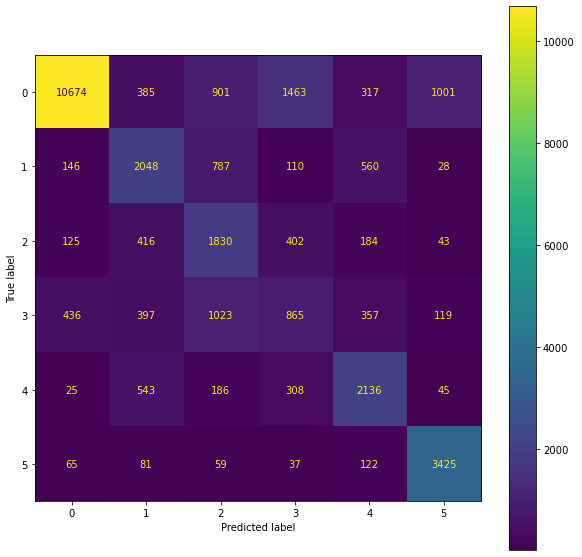

In [60]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [72]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms']] [0.6628329489083383] [0.6206539736428384]


## DNN w/ ZC/SSC/WL

In [73]:
feature_set = ["zc", "ssc", "wl"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 6) y_train shape: (72554,)
X_test shape: (31649, 6) y_test shape: (31649,)


In [75]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 12s 9ms/step - loss: 1.0472 - accuracy: 0.6096 - val_loss: 0.7160 - val_accuracy: 0.7274
Epoch 2/30
1157/1157 [==============================] - 10s 9ms/step - loss: 0.9342 - accuracy: 0.6371 - val_loss: 0.7341 - val_accuracy: 0.7161
Epoch 3/30
1157/1157 [==============================] - 10s 9ms/step - loss: 0.9128 - accuracy: 0.6440 - val_loss: 0.7102 - val_accuracy: 0.7289
Epoch 4/30
1157/1157 [==============================] - 9s 8ms/step - loss: 0.8911 - accuracy: 0.6491 - val_loss: 0.7503 - val_accuracy: 0.7206
Epoch 5/30
1157/1157 [==============================] - 10s 8ms/step - loss: 0.8864 - accuracy: 0.6503 - val_loss: 0.7675 - val_accuracy: 0.7159
Epoch 6/30
1157/1157 [==============================] - 12s 11ms/step - loss: 0.8722 - accuracy: 0.6573 - val_loss: 0.7178 - val_accuracy: 0.7292
Epoch 7/30
1157/1157 [==============================] - 11s 9ms/step - loss: 0.8681 - accuracy: 0.6567 - val_loss: 0.7131 - val_ac

Test Accuracy: 0.7373692691712218 Balanced Test Accuracy: 0.654371098063009
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     14741
           1       0.57      0.55      0.56      3679
           2       0.38      0.48      0.42      3000
           3       0.32      0.30      0.31      3197
           4       0.69      0.77      0.73      3243
           5       0.92      0.96      0.94      3789

    accuracy                           0.74     31649
   macro avg       0.63      0.65      0.64     31649
weighted avg       0.75      0.74      0.74     31649



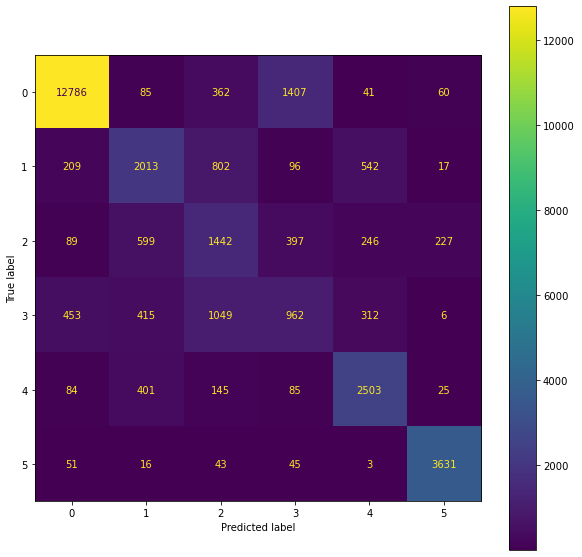

In [76]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [77]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl']] [0.6628329489083383, 0.7373692691712218] [0.6206539736428384, 0.654371098063009]


## DNN w/ ZC/SSC/WL + MAV (Hudgins)

In [78]:
feature_set = ["zc", "ssc", "wl", "mav"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 8) y_train shape: (72554,)
X_test shape: (31649, 8) y_test shape: (31649,)


In [79]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 7s 6ms/step - loss: 1.0464 - accuracy: 0.6116 - val_loss: 0.6630 - val_accuracy: 0.7532
Epoch 2/30
1157/1157 [==============================] - 9s 7ms/step - loss: 0.9114 - accuracy: 0.6506 - val_loss: 0.6766 - val_accuracy: 0.7497
Epoch 3/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.8717 - accuracy: 0.6644 - val_loss: 0.6825 - val_accuracy: 0.7472
Epoch 4/30
1157/1157 [==============================] - 9s 8ms/step - loss: 0.8400 - accuracy: 0.6726 - val_loss: 0.6937 - val_accuracy: 0.7397
Epoch 5/30
1157/1157 [==============================] - 11s 9ms/step - loss: 0.8250 - accuracy: 0.6783 - val_loss: 0.7409 - val_accuracy: 0.7271
Epoch 6/30
1157/1157 [==============================] - 9s 8ms/step - loss: 0.8075 - accuracy: 0.6840 - val_loss: 0.6946 - val_accuracy: 0.7468
Epoch 7/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.7978 - accuracy: 0.6883 - val_loss: 0.6861 - val_accuracy

Test Accuracy: 0.7682707194540112 Balanced Test Accuracy: 0.7044562592129604
              precision    recall  f1-score   support

           0       0.96      0.87      0.91     14741
           1       0.58      0.64      0.61      3679
           2       0.42      0.55      0.47      3000
           3       0.41      0.46      0.43      3197
           4       0.82      0.76      0.79      3243
           5       0.96      0.95      0.95      3789

    accuracy                           0.77     31649
   macro avg       0.69      0.70      0.70     31649
weighted avg       0.79      0.77      0.78     31649



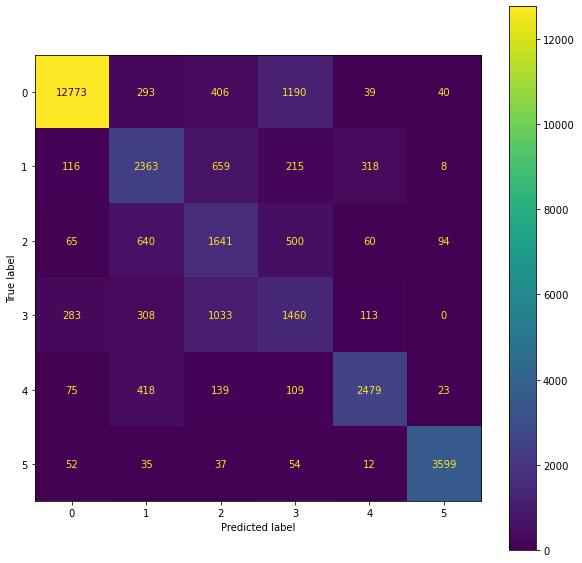

In [80]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [81]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav']] [0.6628329489083383, 0.7373692691712218, 0.7682707194540112] [0.6206539736428384, 0.654371098063009, 0.7044562592129604]


## DNN w/ ZC/SSC/WL + RMS

In [82]:
feature_set = ["zc", "ssc", "wl", "rms"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 8) y_train shape: (72554,)
X_test shape: (31649, 8) y_test shape: (31649,)


In [83]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 8s 6ms/step - loss: 1.0403 - accuracy: 0.6132 - val_loss: 0.7526 - val_accuracy: 0.7214
Epoch 2/30
1157/1157 [==============================] - 9s 8ms/step - loss: 0.9014 - accuracy: 0.6555 - val_loss: 0.6946 - val_accuracy: 0.7445
Epoch 3/30
1157/1157 [==============================] - 12s 10ms/step - loss: 0.8592 - accuracy: 0.6643 - val_loss: 0.6744 - val_accuracy: 0.7445
Epoch 4/30
1157/1157 [==============================] - 11s 10ms/step - loss: 0.8363 - accuracy: 0.6739 - val_loss: 0.7010 - val_accuracy: 0.7359
Epoch 5/30
1157/1157 [==============================] - 12s 11ms/step - loss: 0.8226 - accuracy: 0.6788 - val_loss: 0.7030 - val_accuracy: 0.7441
Epoch 6/30
1157/1157 [==============================] - 12s 11ms/step - loss: 0.8043 - accuracy: 0.6870 - val_loss: 0.6923 - val_accuracy: 0.7423
Epoch 7/30
1157/1157 [==============================] - 9s 8ms/step - loss: 0.7966 - accuracy: 0.6908 - val_loss: 0.6819 - val_a

Test Accuracy: 0.7596764510727038 Balanced Test Accuracy: 0.6991360030686783
              precision    recall  f1-score   support

           0       0.96      0.85      0.90     14741
           1       0.55      0.67      0.61      3679
           2       0.44      0.53      0.48      3000
           3       0.41      0.42      0.41      3197
           4       0.77      0.77      0.77      3243
           5       0.92      0.95      0.93      3789

    accuracy                           0.76     31649
   macro avg       0.67      0.70      0.68     31649
weighted avg       0.78      0.76      0.77     31649



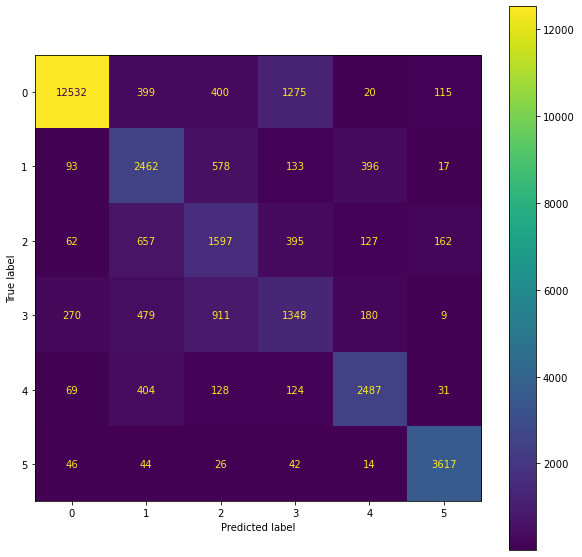

In [84]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [85]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms']] [0.6628329489083383, 0.7373692691712218, 0.7682707194540112, 0.7596764510727038] [0.6206539736428384, 0.654371098063009, 0.7044562592129604, 0.6991360030686783]


## DNN w/ ZC/SSC/WL + VAR

In [87]:
feature_set = ["zc", "ssc", "wl", "var"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 8) y_train shape: (72554,)
X_test shape: (31649, 8) y_test shape: (31649,)


In [88]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 10s 7ms/step - loss: 1.0161 - accuracy: 0.6213 - val_loss: 0.7607 - val_accuracy: 0.7180
Epoch 2/30
1157/1157 [==============================] - 12s 11ms/step - loss: 0.8890 - accuracy: 0.6603 - val_loss: 0.6949 - val_accuracy: 0.7469
Epoch 3/30
1157/1157 [==============================] - 11s 10ms/step - loss: 0.8462 - accuracy: 0.6741 - val_loss: 0.6522 - val_accuracy: 0.7537
Epoch 4/30
1157/1157 [==============================] - 12s 11ms/step - loss: 0.8298 - accuracy: 0.6802 - val_loss: 0.6893 - val_accuracy: 0.7444
Epoch 5/30
1157/1157 [==============================] - 12s 11ms/step - loss: 0.8154 - accuracy: 0.6826 - val_loss: 0.7174 - val_accuracy: 0.7350
Epoch 6/30
1157/1157 [==============================] - 11s 9ms/step - loss: 0.8074 - accuracy: 0.6864 - val_loss: 0.6701 - val_accuracy: 0.7484
Epoch 7/30
1157/1157 [==============================] - 11s 9ms/step - loss: 0.7921 - accuracy: 0.6940 - val_loss: 0.7075 - va

Test Accuracy: 0.765300641410471 Balanced Test Accuracy: 0.6994342071830403
              precision    recall  f1-score   support

           0       0.96      0.87      0.91     14741
           1       0.59      0.66      0.62      3679
           2       0.40      0.58      0.47      3000
           3       0.42      0.37      0.39      3197
           4       0.80      0.77      0.79      3243
           5       0.91      0.95      0.93      3789

    accuracy                           0.77     31649
   macro avg       0.68      0.70      0.69     31649
weighted avg       0.79      0.77      0.77     31649



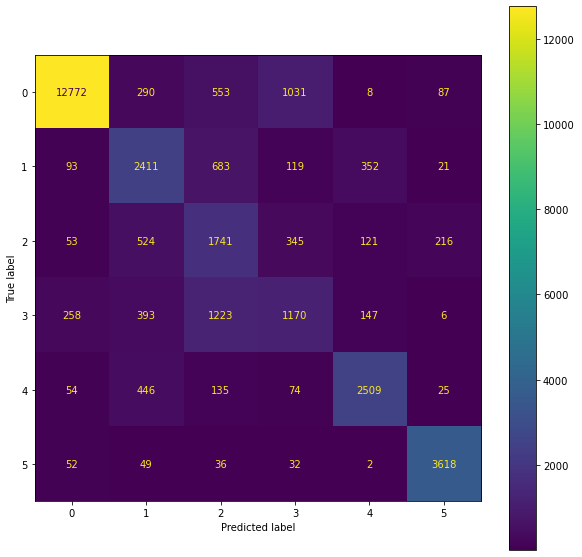

In [89]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [90]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var']] [0.6628329489083383, 0.7373692691712218, 0.7682707194540112, 0.7596764510727038, 0.765300641410471] [0.6206539736428384, 0.654371098063009, 0.7044562592129604, 0.6991360030686783, 0.6994342071830403]


## DNN w/ ZC/SSC/WL + MAV + RMS

In [91]:
feature_set = ["zc", "ssc", "wl", "mav", "rms"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 10) y_train shape: (72554,)
X_test shape: (31649, 10) y_test shape: (31649,)


In [92]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 8s 6ms/step - loss: 1.0557 - accuracy: 0.6102 - val_loss: 0.7096 - val_accuracy: 0.7374
Epoch 2/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.9014 - accuracy: 0.6583 - val_loss: 0.6573 - val_accuracy: 0.7565
Epoch 3/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.8523 - accuracy: 0.6721 - val_loss: 0.6970 - val_accuracy: 0.7408
Epoch 4/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.8234 - accuracy: 0.6843 - val_loss: 0.6940 - val_accuracy: 0.7428
Epoch 5/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.8006 - accuracy: 0.6922 - val_loss: 0.6607 - val_accuracy: 0.7581
Epoch 6/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.7830 - accuracy: 0.6972 - val_loss: 0.6937 - val_accuracy: 0.7467
Epoch 7/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.7656 - accuracy: 0.7055 - val_loss: 0.6521 - val_accuracy:

Test Accuracy: 0.7760750734620367 Balanced Test Accuracy: 0.7162206581308125
              precision    recall  f1-score   support

           0       0.96      0.86      0.91     14741
           1       0.62      0.69      0.65      3679
           2       0.48      0.47      0.47      3000
           3       0.40      0.55      0.46      3197
           4       0.81      0.78      0.79      3243
           5       0.95      0.95      0.95      3789

    accuracy                           0.78     31649
   macro avg       0.70      0.72      0.71     31649
weighted avg       0.80      0.78      0.79     31649



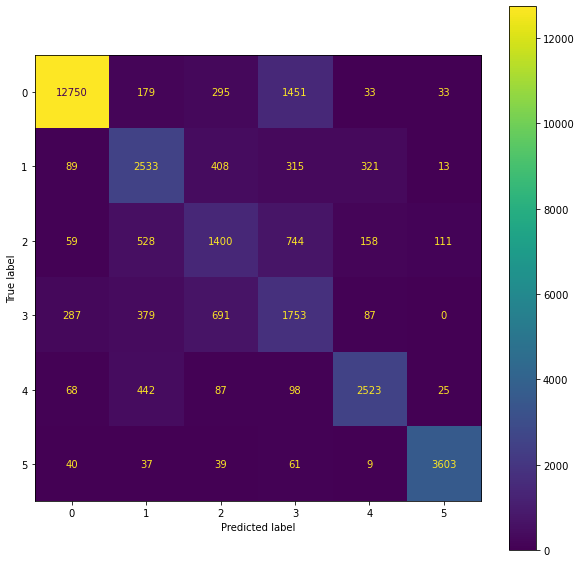

In [93]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [94]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms']] [0.6628329489083383, 0.7373692691712218, 0.7682707194540112, 0.7596764510727038, 0.765300641410471, 0.7760750734620367] [0.6206539736428384, 0.654371098063009, 0.7044562592129604, 0.6991360030686783, 0.6994342071830403, 0.7162206581308125]


## DNN w/ ZC/SSC/WL + MAV + VAR

In [95]:
feature_set = ["zc", "ssc", "wl", "mav", "var"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 10) y_train shape: (72554,)
X_test shape: (31649, 10) y_test shape: (31649,)


In [96]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 9s 7ms/step - loss: 1.0478 - accuracy: 0.6105 - val_loss: 0.7271 - val_accuracy: 0.7293
Epoch 2/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.8943 - accuracy: 0.6571 - val_loss: 0.6719 - val_accuracy: 0.7534
Epoch 3/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.8490 - accuracy: 0.6681 - val_loss: 0.6950 - val_accuracy: 0.7445
Epoch 4/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.8231 - accuracy: 0.6809 - val_loss: 0.6910 - val_accuracy: 0.7431
Epoch 5/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.8080 - accuracy: 0.6831 - val_loss: 0.6835 - val_accuracy: 0.7501
Epoch 6/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.7904 - accuracy: 0.6928 - val_loss: 0.6635 - val_accuracy: 0.7540
Epoch 7/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.7760 - accuracy: 0.6972 - val_loss: 0.7283 - val_accuracy:

Test Accuracy: 0.7787607823311953 Balanced Test Accuracy: 0.7248575637073574
              precision    recall  f1-score   support

           0       0.96      0.86      0.91     14741
           1       0.63      0.67      0.65      3679
           2       0.46      0.59      0.52      3000
           3       0.43      0.50      0.46      3197
           4       0.80      0.77      0.79      3243
           5       0.95      0.95      0.95      3789

    accuracy                           0.78     31649
   macro avg       0.70      0.72      0.71     31649
weighted avg       0.80      0.78      0.79     31649



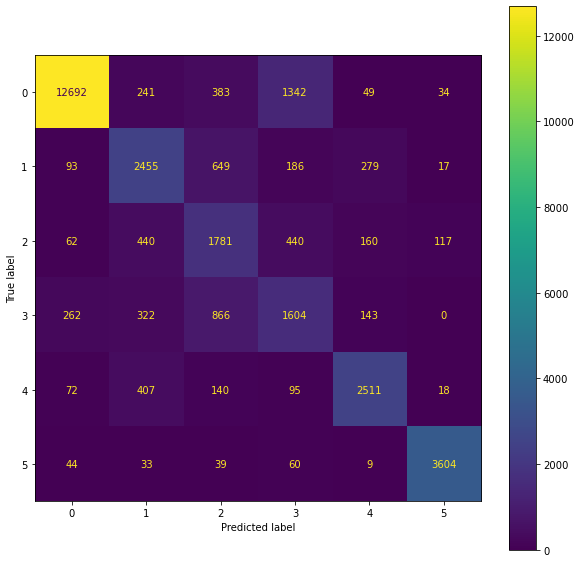

In [97]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [98]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms'], ['zc', 'ssc', 'wl', 'mav', 'var']] [0.6628329489083383, 0.7373692691712218, 0.7682707194540112, 0.7596764510727038, 0.765300641410471, 0.7760750734620367, 0.7787607823311953] [0.6206539736428384, 0.654371098063009, 0.7044562592129604, 0.6991360030686783, 0.6994342071830403, 0.7162206581308125, 0.7248575637073574]


## DNN w/ ZC/SSC/WL + RMS + VAR

In [99]:
feature_set = ["zc", "ssc", "wl", "rms", "var"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 10) y_train shape: (72554,)
X_test shape: (31649, 10) y_test shape: (31649,)


In [100]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 9s 7ms/step - loss: 1.0300 - accuracy: 0.6155 - val_loss: 0.6767 - val_accuracy: 0.7481
Epoch 2/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.8893 - accuracy: 0.6562 - val_loss: 0.7066 - val_accuracy: 0.7489
Epoch 3/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.8487 - accuracy: 0.6687 - val_loss: 0.6720 - val_accuracy: 0.7571
Epoch 4/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.8219 - accuracy: 0.6795 - val_loss: 0.6831 - val_accuracy: 0.7546
Epoch 5/30
1157/1157 [==============================] - 9s 8ms/step - loss: 0.8095 - accuracy: 0.6868 - val_loss: 0.6594 - val_accuracy: 0.7654
Epoch 6/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.7865 - accuracy: 0.6965 - val_loss: 0.6783 - val_accuracy: 0.7582
Epoch 7/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.7796 - accuracy: 0.6974 - val_loss: 0.6783 - val_accuracy:

Test Accuracy: 0.778034061107776 Balanced Test Accuracy: 0.719348817074874
              precision    recall  f1-score   support

           0       0.96      0.87      0.91     14741
           1       0.63      0.65      0.64      3679
           2       0.44      0.61      0.51      3000
           3       0.44      0.48      0.46      3197
           4       0.80      0.75      0.78      3243
           5       0.95      0.95      0.95      3789

    accuracy                           0.78     31649
   macro avg       0.70      0.72      0.71     31649
weighted avg       0.80      0.78      0.79     31649



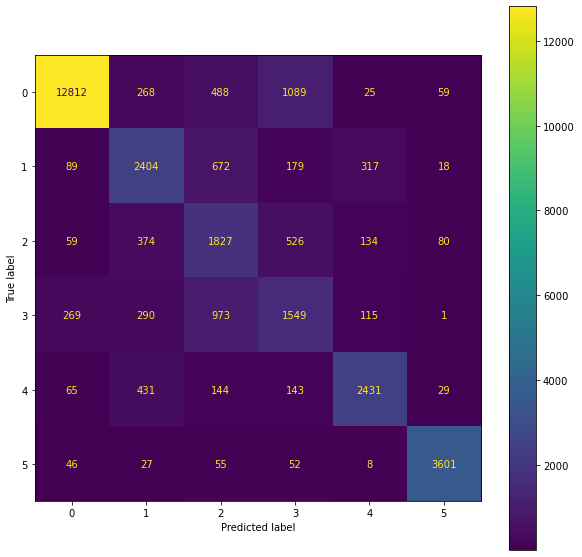

In [101]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [102]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms'], ['zc', 'ssc', 'wl', 'mav', 'var'], ['zc', 'ssc', 'wl', 'rms', 'var']] [0.6628329489083383, 0.7373692691712218, 0.7682707194540112, 0.7596764510727038, 0.765300641410471, 0.7760750734620367, 0.7787607823311953, 0.778034061107776] [0.6206539736428384, 0.654371098063009, 0.7044562592129604, 0.6991360030686783, 0.6994342071830403, 0.7162206581308125, 0.7248575637073574, 0.719348817074874]


## DNN w/ ZC/SSC/WL + MAV + RMS + VAR

In [103]:
feature_set = ["zc", "ssc", "wl", "mav", "rms", "var"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 12) y_train shape: (72554,)
X_test shape: (31649, 12) y_test shape: (31649,)


In [104]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 9s 7ms/step - loss: 1.0550 - accuracy: 0.6111 - val_loss: 0.7085 - val_accuracy: 0.7292
Epoch 2/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.8916 - accuracy: 0.6573 - val_loss: 0.6975 - val_accuracy: 0.7459
Epoch 3/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.8489 - accuracy: 0.6748 - val_loss: 0.7286 - val_accuracy: 0.7290
Epoch 4/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.8140 - accuracy: 0.6869 - val_loss: 0.7093 - val_accuracy: 0.7500
Epoch 5/30
1157/1157 [==============================] - 9s 8ms/step - loss: 0.7969 - accuracy: 0.6927 - val_loss: 0.7456 - val_accuracy: 0.7319
Epoch 6/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.7747 - accuracy: 0.7006 - val_loss: 0.7073 - val_accuracy: 0.7551
Epoch 7/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.7632 - accuracy: 0.7063 - val_loss: 0.6649 - val_accuracy:

Test Accuracy: 0.7795822932794085 Balanced Test Accuracy: 0.7301787098027787
              precision    recall  f1-score   support

           0       0.96      0.85      0.90     14741
           1       0.65      0.71      0.68      3679
           2       0.48      0.51      0.50      3000
           3       0.40      0.57      0.47      3197
           4       0.84      0.79      0.81      3243
           5       0.94      0.96      0.95      3789

    accuracy                           0.78     31649
   macro avg       0.71      0.73      0.72     31649
weighted avg       0.81      0.78      0.79     31649



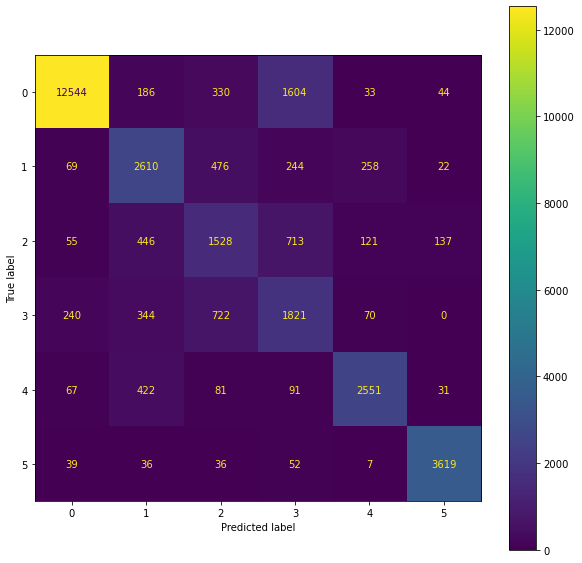

In [105]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [106]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms'], ['zc', 'ssc', 'wl', 'mav', 'var'], ['zc', 'ssc', 'wl', 'rms', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms', 'var']] [0.6628329489083383, 0.7373692691712218, 0.7682707194540112, 0.7596764510727038, 0.765300641410471, 0.7760750734620367, 0.7787607823311953, 0.778034061107776, 0.7795822932794085] [0.6206539736428384, 0.654371098063009, 0.7044562592129604, 0.6991360030686783, 0.6994342071830403, 0.7162206581308125, 0.7248575637073574, 0.719348817074874, 0.7301787098027787]


## DNN w/ ZC/SSC/WL + iEMG + VAR + WAMP (Du)

In [107]:
feature_set = ["zc", "ssc", "wl", "iemg", "var", "wamp"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 12) y_train shape: (72554,)
X_test shape: (31649, 12) y_test shape: (31649,)


In [108]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 9s 7ms/step - loss: 1.0532 - accuracy: 0.6129 - val_loss: 0.6738 - val_accuracy: 0.7533
Epoch 2/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.8872 - accuracy: 0.6602 - val_loss: 0.7048 - val_accuracy: 0.7401
Epoch 3/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.8484 - accuracy: 0.6746 - val_loss: 0.6688 - val_accuracy: 0.7548
Epoch 4/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.8257 - accuracy: 0.6785 - val_loss: 0.6648 - val_accuracy: 0.7576
Epoch 5/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.7991 - accuracy: 0.6901 - val_loss: 0.7394 - val_accuracy: 0.7342
Epoch 6/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.7851 - accuracy: 0.6945 - val_loss: 0.7159 - val_accuracy: 0.7399
Epoch 7/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.7729 - accuracy: 0.7022 - val_loss: 0.6587 - val_accuracy:

Test Accuracy: 0.779519100129546 Balanced Test Accuracy: 0.7228755109079582
              precision    recall  f1-score   support

           0       0.96      0.86      0.91     14741
           1       0.61      0.73      0.67      3679
           2       0.47      0.56      0.51      3000
           3       0.41      0.46      0.44      3197
           4       0.84      0.77      0.80      3243
           5       0.94      0.95      0.95      3789

    accuracy                           0.78     31649
   macro avg       0.71      0.72      0.71     31649
weighted avg       0.80      0.78      0.79     31649



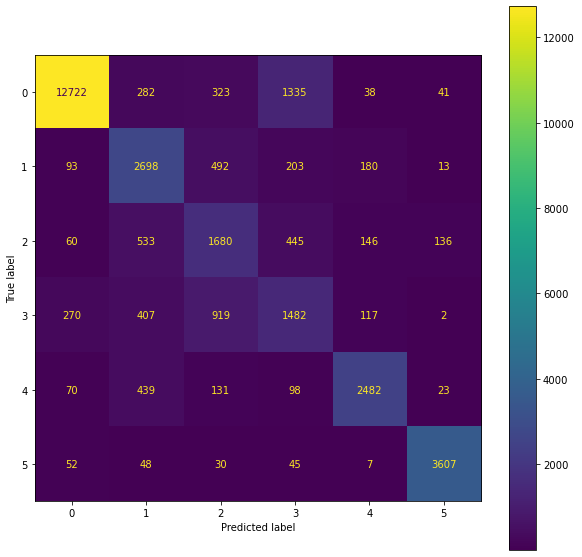

In [109]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [110]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms'], ['zc', 'ssc', 'wl', 'mav', 'var'], ['zc', 'ssc', 'wl', 'rms', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms', 'var'], ['zc', 'ssc', 'wl', 'iemg', 'var', 'wamp']] [0.6628329489083383, 0.7373692691712218, 0.7682707194540112, 0.7596764510727038, 0.765300641410471, 0.7760750734620367, 0.7787607823311953, 0.778034061107776, 0.7795822932794085, 0.779519100129546] [0.6206539736428384, 0.654371098063009, 0.7044562592129604, 0.6991360030686783, 0.6994342071830403, 0.7162206581308125, 0.7248575637073574, 0.719348817074874, 0.7301787098027787, 0.7228755109079582]


## DNN w/ Skewness/RMS/iEMG/AR(P=11) + Hjorth

In [23]:
feature_set = ["skewness", "rms", "iemg", "ar_coeff", "hjorth"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 34) y_train shape: (72554,)
X_test shape: (31649, 34) y_test shape: (31649,)


In [24]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 8s 6ms/step - loss: 1.1643 - accuracy: 0.5817 - val_loss: 0.6519 - val_accuracy: 0.7707
Epoch 2/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.8751 - accuracy: 0.6813 - val_loss: 0.6100 - val_accuracy: 0.7884
Epoch 3/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.7948 - accuracy: 0.7052 - val_loss: 0.6071 - val_accuracy: 0.7856
Epoch 4/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.7434 - accuracy: 0.7265 - val_loss: 0.6006 - val_accuracy: 0.7898
Epoch 5/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.7082 - accuracy: 0.7394 - val_loss: 0.5732 - val_accuracy: 0.7975
Epoch 6/30
1157/1157 [==============================] - 6s 6ms/step - loss: 0.6773 - accuracy: 0.7503 - val_loss: 0.5676 - val_accuracy: 0.8021
Epoch 7/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.6474 - accuracy: 0.7629 - val_loss: 0.5571 - val_accuracy:

Test Accuracy: 0.8330068250758341 Balanced Test Accuracy: 0.8007907917689643
              precision    recall  f1-score   support

           0       0.96      0.88      0.92     14740
           1       0.74      0.80      0.77      3679
           2       0.58      0.66      0.62      3000
           3       0.58      0.66      0.62      3197
           4       0.84      0.84      0.84      3243
           5       0.95      0.96      0.95      3789

    accuracy                           0.83     31648
   macro avg       0.77      0.80      0.79     31648
weighted avg       0.85      0.83      0.84     31648



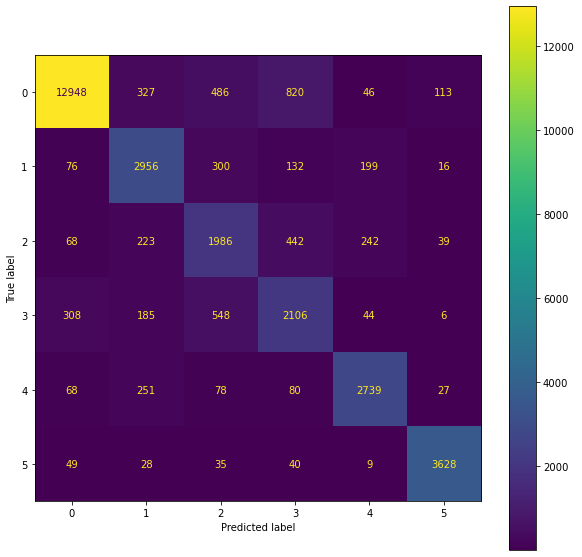

In [25]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [26]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms'], ['zc', 'ssc', 'wl', 'mav', 'var'], ['zc', 'ssc', 'wl', 'rms', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms', 'var'], ['zc', 'ssc', 'wl', 'iemg', 'var', 'wamp'], ['skewness', 'rms', 'iemg', 'ar_coeff', 'hjorth']] [0.6628329489083383, 0.7373692691712218, 0.7682707194540112, 0.7596764510727038, 0.765300641410471, 0.7760750734620367, 0.7787607823311953, 0.778034061107776, 0.7795822932794085, 0.779519100129546, 0.8330068250758341] [0.6206539736428384, 0.654371098063009, 0.7044562592129604, 0.6991360030686783, 0.6994342071830403, 0.7162206581308125, 0.7248575637073574, 0.719348817074874, 0.7301787098027787, 0.7228755109079582, 0.8007907917689643]


In [27]:
np.save("feature_sets", np.array(feature_sets))
np.save("accuracies", np.array(accuracies))
np.save("balanced_accuracies", np.array(balanced_accuracies))

In [19]:
feature_sets = np.load("feature_sets.npy", allow_pickle=True).tolist()
accuracies = np.load("accuracies.npy", allow_pickle=True).tolist()
balanced_accuracies = np.load("balanced_accuracies.npy", allow_pickle=True).tolist()

## DNN w/ Frequency Domain Features (MNF/MDF/MMNF/MMDF)

In [ ]:
feature_set = ["mnf", "mdf", "mmnf", "mmdf"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride, False)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

In [ ]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

In [ ]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [ ]:
print(feature_sets, accuracies, balanced_accuracies)

## Feature Sets Accuracies

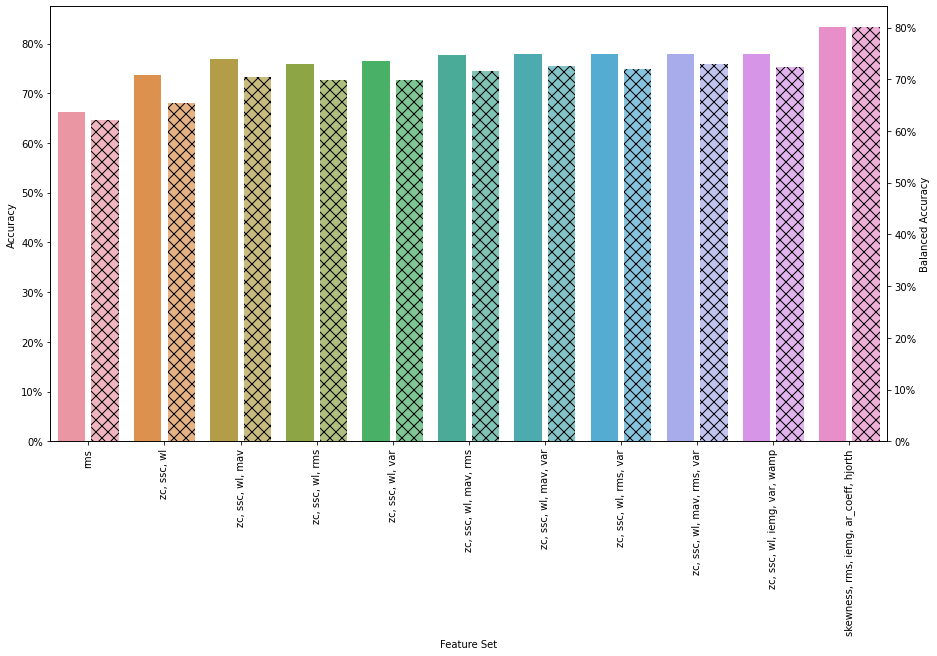

In [63]:
from matplotlib.ticker import PercentFormatter

results = pd.DataFrame({
    'Feature Set': [", ".join(ft) for ft in feature_sets],
    'Accuracy': accuracies,
    'Balanced Accuracy': balanced_accuracies
})

data1 = results[['Feature Set', 'Accuracy']]
data2 = results[['Feature Set', 'Balanced Accuracy']]

plt.figure(figsize=(15, 8))
width_scale = 0.45

ax = sns.barplot(x='Feature Set', y='Accuracy', data=data1)
for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width_scale)

ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.tick_params(axis='x', rotation=90)

ax2 = ax.twinx()
sns.barplot(x='Feature Set', y='Balanced Accuracy', data=data2, alpha=0.7, hatch='xx', ax=ax2)
for bar in ax2.containers[0]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width_scale))
    bar.set_width(w * width_scale)
ax2.yaxis.set_major_formatter(PercentFormatter(1))
ax2.tick_params(axis='x', rotation=90)

plt.show()

In [66]:
for fs, acc, bal_acc in zip(feature_sets, accuracies, balanced_accuracies):
    print("Feature Set: {0}   Accuracy: {1}   Balanced Accuracy: {2}".format(",".join(fs), acc*100, bal_acc*100))

Feature Set: rms   Accuracy: 66.28329489083383   Balanced Accuracy: 62.06539736428384
Feature Set: zc,ssc,wl   Accuracy: 73.73692691712218   Balanced Accuracy: 65.4371098063009
Feature Set: zc,ssc,wl,mav   Accuracy: 76.82707194540112   Balanced Accuracy: 70.44562592129604
Feature Set: zc,ssc,wl,rms   Accuracy: 75.96764510727037   Balanced Accuracy: 69.91360030686783
Feature Set: zc,ssc,wl,var   Accuracy: 76.5300641410471   Balanced Accuracy: 69.94342071830403
Feature Set: zc,ssc,wl,mav,rms   Accuracy: 77.60750734620368   Balanced Accuracy: 71.62206581308125
Feature Set: zc,ssc,wl,mav,var   Accuracy: 77.87607823311953   Balanced Accuracy: 72.48575637073574
Feature Set: zc,ssc,wl,rms,var   Accuracy: 77.8034061107776   Balanced Accuracy: 71.93488170748739
Feature Set: zc,ssc,wl,mav,rms,var   Accuracy: 77.95822932794086   Balanced Accuracy: 73.01787098027786
Feature Set: zc,ssc,wl,iemg,var,wamp   Accuracy: 77.9519100129546   Balanced Accuracy: 72.28755109079582
Feature Set: skewness,rms,ie